# AI & Cognition Project : PMBOK

### Packages

In [ ]:
!pip install -q langchain-community
!pip install -q neo4j
!pip install -q langchain-groq
!pip install -q langchain-huggingface
!pip install -q langchain-core
!pip install -q langchain-experimental
!pip install langchain
!pip install torch_geometric
!pip install transformers
!pip install pandas networkx scikit-learn transformers
!pip install sentence-transformers
!pip install nltk
!python -m spacy download en_core_web_sm
!pip install spacy PyPDF2
!pip install reportlab
!pip install pikepdf
!pip install pymupdf opencv-python pdfplumber
!pip install transformers
!pip install textblob
!pip install language_tool_python
!pip install llama-index llama-index-core llama-index-embeddings-openai llama-parse
!pip install llama-index-postprocessor-flag-embedding-reranker
!pip install git+https://github.com/FlagOpen/FlagEmbedding.git
!pip install llama-index-vector-stores-lancedb
!pip install --upgrade --quiet  langchain langchain-community langchainhub langchain-chroma bs4 lancedb
!pip  install unstructured
!pip install llama-index-embeddings-huggingface
!pip install llama-index-embeddings-instructor
!pip install -qU langchain-groq
!pip install llama-index-llms-langchain
!pip install llama-index-embeddings-huggingface
!pip install llama-index-embeddings-instructor
!pip install pytesseract
!apt install tesseract-ocr

### Libraries

In [ ]:
import os
import pandas as pd
import json
import bs4
from langchain import hub
from langchain_community.document_loaders import WebBaseLoader
from langchain_core.output_parsers import StrOutputParser
from langchain_core.runnables import RunnablePassthrough
from langchain_community.document_loaders import TextLoader
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain_groq import ChatGroq
from langchain_community.graphs import Neo4jGraph
from langchain.vectorstores.neo4j_vector import Neo4jVector
from langchain.chains import RetrievalQA
from langchain_huggingface import HuggingFaceEmbeddings
from langchain.prompts import (
    PromptTemplate,
    HumanMessagePromptTemplate,
    SystemMessagePromptTemplate
    )
from langchain_core.prompts import ChatPromptTemplate
from pathlib import Path
import random
import numpy as np
import uuid
import sys
from neo4j import GraphDatabase
import textwrap
import nltk
from llama_index.vector_stores.lancedb import LanceDBVectorStore
from llama_index.core import SimpleDirectoryReader, Document, StorageContext
from llama_index.core import VectorStoreIndex
from llama_index.core import VectorStoreIndex
from llama_index.core import SimpleDirectoryReader
from llama_index.postprocessor.flag_embedding_reranker import (
    FlagEmbeddingReranker,
)
sys.path.append("..")
nltk.download('wordnet')

### Set the Environment

In [ ]:
os.environ["GROQ_API_KEY"] = "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"
os.environ["NEO4J_USERNAME"] = "neo4j"
os.environ["NEO4J_PASSWORD"] = "JQUYuvvbYAkO4sSkhOfcQggiGlkdPMXcz5acyYLrh4M"
os.environ["NEO4J_URI"] = "neo4j+s://eebf8c49.databases.neo4j.io"
url = os.environ["NEO4J_URI"]
username = os.environ["NEO4J_USERNAME"]
password = os.environ["NEO4J_PASSWORD"]
graph = Neo4jGraph()

In [ ]:
from huggingface_hub import notebook_login
notebook_login()

## Text Preprocessing

### Figure Extraction and Description

#### Load the model for the figure description

In [ ]:
from llama_index.vector_stores.lancedb import LanceDBVectorStore
vector_store_pdf = LanceDBVectorStore(uri="/tmp/lancedb_lamaindex")

In [ ]:
from llama_index.embeddings.huggingface import HuggingFaceEmbedding
embedding_model = HuggingFaceEmbedding(model_name="BAAI/bge-small-en-v1.5")
llm = ChatGroq(model="llama-3.2-90b-text-preview",temperature=0)

In [ ]:
# using llamaparser with LlamaIndex

from llama_index.postprocessor.flag_embedding_reranker import (
    FlagEmbeddingReranker,
)

from llama_parse import LlamaParse

pdf_table_LlamaParse = LlamaParse(result_type="markdown").load_data(
    "PMBOK-7th.pdf"
)

Started parsing the file under job_id dff1293e-e11b-4899-a38c-e0dfaf755fb5
..

In [ ]:
vector_store_lamaparser = LanceDBVectorStore(uri="/tmp/lancedb_parser")
storage_context_lamaparser = StorageContext.from_defaults(
    vector_store=vector_store_lamaparser
)
lance_index_lamaparser = VectorStoreIndex.from_documents(
    pdf_table_LlamaParse, storage_context=storage_context_lamaparser,embed_model=embedding_model
)

reranker = FlagEmbeddingReranker(
    top_n=5,
    model="BAAI/bge-reranker-large",
)

Lance_index_query_lamaparser = lance_index_lamaparser.as_query_engine(
    similarity_top_k=10, node_postprocessors=[reranker],llm=llm
)


KeyboardInterrupt: 

#### Extract the figure names and put them in a list

In [ ]:
import fitz  # PyMuPDF
import re

def extract_figures_and_tables(pdf_path):
    document = fitz.open(pdf_path)
    figures_and_tables = []

    figure_pattern = r'Figure\s+[Xx]?\d+-\d+\.\s.+'
    table_pattern = r'Table\s+[Xx]?\d+-\d+\.\s.+'

    for page in document:
        text = page.get_text()

        lines = text.split('\n')

        for line in lines:
            if re.match(figure_pattern, line) or re.match(table_pattern, line):
                # Exclude lines that are just table or figure numbers without descriptions
                if not re.search(r'^\s*Table\s+[Xx]?\d+-\d+\.\s*$', line) and not re.search(r'^\s*Figure\s+[Xx]?\d+-\d+\.\s*$', line):
                    figures_and_tables.append(line.strip())

    document.close()

    return figures_and_tables

pdf_path = 'PMBOK-7th.pdf'
List_Figures_Tables = extract_figures_and_tables(pdf_path)

print(List_Figures_Tables)

['Figure 2-1. Example of a System for Value Delivery', 'Figure 2-2. Components of a Sample System for Value Delivery', 'Figure 2-3. Example of Information Flow', 'Figure 2-4. Sample Product Life Cycle', 'Figure 3-1. Overlap of Project Management and General Management Principles', 'Figure 3-2. Be a Diligent, Respectful, and Caring Steward', 'Figure 3-3. Create a Collaborative Project Team Environment', 'Figure 3-4. Effectively Engage with Stakeholders', 'Figure 3-5. Focus on Value', 'Figure 3-6. Recognize, Evaluate, and Respond to System Interactions', 'Figure 3-7. Demonstrate Leadership Behaviors', 'Figure 3-8. Tailor Based on Context', 'Figure 3-9. Build Quality into Processes and Deliverables', 'Figure 3-10. Navigate Complexity', 'Figure 3-11. Optimize Risk Responses', 'Figure 3-12. Embrace Adaptability and Resiliency', 'Figure 3-13. Enable Change to Achieve the Envisioned Future State', 'Figure 1-1. Relationship between Project Management Principles and Project Performance Domains'

#### Save the list to a .txt file

In [ ]:
with open('List_Figures_Tables.txt', 'w') as txt_file:
    for item in List_Figures_Tables:
        txt_file.write(item + '\n')

#### Figure description

In [ ]:
def describe_figure(title):
    query_parser = f"{title}"
    response = Lance_index_query_lamaparser.query(query_parser)
    return response

figures_with_descriptions = []

for title in List_Figures_Tables:
    description = describe_figure(title)
    figures_with_descriptions.append((title, description))

for title, description in figures_with_descriptions:
    print(f"Title: {title}")
    print(f"Description: {description}")
    print("-" * 40)

##### Save the tuple {Figure,Description} to a .csv file

In [ ]:
import csv

with open('figures_descriptions.csv', 'w', newline='') as csv_file:
    writer = csv.writer(csv_file)
    writer.writerows(figures_with_descriptions)  # Write the tuple rows

#### Extract text and include figure descriptions

In [ ]:
import fitz
import re

def extract_text_cleaned(pdf_path, header_lines=1, footer_lines=1):
    """
    Extracts text from the entire PDF and removes headers, footers, and page numbers.

    Args:
    - pdf_path: Path to the PDF file.
    - header_lines: Approximate number of header lines to remove (default 1).
    - footer_lines: Approximate number of footer lines to remove (default 1).

    Returns:
    - Cleaned text with headers, footers, and page numbers removed.
    """
    text = ""
    with fitz.open(pdf_path) as pdf_document:
        for page_num in range(len(pdf_document)):
            page = pdf_document.load_page(page_num)
            page_text = page.get_text("text").splitlines()

            page_text = page_text[header_lines:]

            if footer_lines > 0:
                page_text = page_text[:-footer_lines]

            if page_text and page_text[-1].strip().isdigit():
                page_text = page_text[:-1]

            cleaned_text = '\n'.join(page_text)
            cleaned_text = re.sub(r'Section \d+\s*–\s*.*', '', cleaned_text)
            cleaned_text = re.sub(r'PMBOK(?:\s*®)?\s*Guide', '', cleaned_text)

            text += cleaned_text.strip() + "\n"

    return text

pdf_path = "PMBOK-7th.pdf"

extracted_text = extract_text_cleaned(pdf_path, header_lines=1, footer_lines=1)

for figure_name, description in figures_with_descriptions:
    if figure_name in extracted_text:
        extracted_text = extracted_text.replace(figure_name, f"{figure_name} - {description}")

output_file = "extracted_text_with_figures.txt"
with open(output_file, "w", encoding="utf-8") as f:
    f.write(extracted_text)

print(f"Extracted text has been saved to {output_file}")

Extracted text has been saved to extracted_text_with_figures.txt


In [ ]:
from reportlab.lib.pagesizes import letter
from reportlab.pdfgen import canvas

def txt_to_pdf(txt_file, pdf_file):
    """
    Converts a text file to a PDF file.

    Args:
    - txt_file: Path to the input text file.
    - pdf_file: Path where the output PDF will be saved.
    """

    c = canvas.Canvas(pdf_file, pagesize=letter)
    width, height = letter

    with open(txt_file, "r", encoding="utf-8") as file:
        text = file.readlines()
        y_position = height - 40

        for line in text:
            c.drawString(40, y_position, line.strip())
            y_position -= 15

            if y_position < 40:
                c.showPage()
                y_position = height - 40

    c.save()

txt_file_path = "extracted_text_with_figures.txt"
pdf_file_path = "extracted_text_with_figures.pdf"
txt_to_pdf(txt_file_path, pdf_file_path)

print(f"Converted {txt_file_path} to {pdf_file_path}")

Converted extracted_text_with_figures.txt to extracted_text_with_figures.pdf


#### Figures extraction to images

In [ ]:
import fitz
import cv2
import numpy as np
from PIL import Image
import io
import re
import os
import pytesseract
from google.colab import files
import shutil


titles_file = "/List_Figures_Tables.txt"
with open(titles_file, 'r') as file:
    figure_titles = [line.strip() for line in file.readlines()]

pdf_document = "/PMBOK.pdf"
pdf = fitz.open(pdf_document)


output_dir = "/extracted_figures/"
os.makedirs(output_dir, exist_ok=True)


def extract_text_from_image(image):

    if image.size == 0:
        return ""

    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    text = pytesseract.image_to_string(gray)
    return text


used_titles = set()
title_index = 0

for page_number in range(32, pdf.page_count + 1):
    page = pdf.load_page(page_number - 1)
    pix = page.get_pixmap(dpi=300)
    img_bytes = pix.tobytes(output="png")


    image = Image.open(io.BytesIO(img_bytes))
    image_np = np.array(image)


    gray = cv2.cvtColor(image_np, cv2.COLOR_BGR2GRAY)
    blurred = cv2.GaussianBlur(gray, (5, 5), 0)
    edges = cv2.Canny(blurred, 50, 150)


    contours, _ = cv2.findContours(edges, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)


    for contour in contours:
        x, y, w, h = cv2.boundingRect(contour)


        if w > 500 and h > 300:
            figure = image_np[y:y+h, x:x+w]


            figure_image = Image.fromarray(figure)


            surrounding_text = ""


            if y - 100 >= 0:
                surrounding_text += extract_text_from_image(image_np[y-100:y, x:x+w])


            if y + h + 100 <= image_np.shape[0]:
                surrounding_text += extract_text_from_image(image_np[y+h:y+h+100, x:x+w])


            for title in figure_titles:
                if title.lower() in surrounding_text.lower() and title not in used_titles:

                    figure_filename = f"{title}.png"


                    figure_filename = re.sub(r'[\\/*?:"<>|]', "_", figure_filename)


                    figure_image.save(os.path.join(output_dir, figure_filename))
                    print(f"Extracted figure from page {page_number} saved as {figure_filename}.")


                    used_titles.add(title)
                    title_index += 1
                    break
    else:
        print(f"No figure matching the criteria was found on page {page_number}.")


if os.listdir(output_dir):

    shutil.make_archive("/content/extracted_figures", 'zip', output_dir)
    print("Figures extracted and saved successfully.")


    files.download("/content/extracted_figures.zip")
else:
    print("No figures found matching the criteria.")

No figure matching the criteria was found on page 32.
No figure matching the criteria was found on page 33.
No figure matching the criteria was found on page 34.
No figure matching the criteria was found on page 35.
Extracted figure from page 36 saved as Figure 2-1. Example of a System for Value Delivery.png.
No figure matching the criteria was found on page 36.
Extracted figure from page 37 saved as Figure 2-2. Components of a Sample System for Value Delivery.png.
No figure matching the criteria was found on page 37.
Extracted figure from page 38 saved as Figure 2-3. Example of Information Flow.png.
No figure matching the criteria was found on page 38.
No figure matching the criteria was found on page 39.
No figure matching the criteria was found on page 40.
No figure matching the criteria was found on page 41.
No figure matching the criteria was found on page 42.
No figure matching the criteria was found on page 43.
No figure matching the criteria was found on page 44.
No figure matc

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

### Method 1 : Nltk with Spacy

#### **Tokenization**

In [ ]:
import fitz
import cv2
import numpy as np
from transformers import BertTokenizer

tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

tokens = tokenizer.tokenize(extracted_text)

filtered_tokens = [token for token in tokens if not token.isdigit()]

token_ids = tokenizer.convert_tokens_to_ids(filtered_tokens)

print(f"Filtered Tokens: {filtered_tokens}")
print(f"Token IDs: {token_ids}")

max_length = 512
token_chunks = [filtered_tokens[i:i + max_length] for i in range(0, len(filtered_tokens), max_length)]
token_id_chunks = [tokenizer.convert_tokens_to_ids(chunk) for chunk in token_chunks]

for i, chunk in enumerate(token_id_chunks):
    print(f"Chunk {i + 1}: {chunk}")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


Filtered Tokens: ['project', 'performance', 'domains', 'a', 'project', 'performance', 'domain', 'is', 'a', 'group', 'of', 'related', 'activities', 'that', 'are', 'critical', 'for', 'the', 'effective', 'delivery', 'of', 'project', 'outcomes', '.', 'project', 'performance', 'domains', 'are', 'interactive', ',', 'inter', '##rel', '##ated', ',', 'and', 'inter', '##de', '##pen', '##dent', 'areas', 'of', 'focus', 'that', 'work', 'in', 'unison', 'to', 'achieve', 'desired', 'project', 'outcomes', '.', 'there', 'are', 'eight', 'project', 'performance', 'domains', ':', '[UNK]', 'stakeholders', ',', '[UNK]', 'team', ',', '[UNK]', 'development', 'approach', 'and', 'life', 'cycle', ',', '[UNK]', 'planning', ',', '[UNK]', 'project', 'work', ',', '[UNK]', 'delivery', ',', '[UNK]', 'measurement', ',', 'and', '[UNK]', 'uncertainty', '.', 'together', 'the', 'performance', 'domains', 'form', 'a', 'unified', 'whole', '.', 'in', 'this', 'way', ',', 'the', 'performance', 'domains', 'operate', 'as', 'an', 'i

In [ ]:
print("Length of Extracted Text:", len(extracted_text))
print(f"Number of Tokens: {len(tokens)}")

Length of Extracted Text: 197322
Number of Tokens: 35781


In [ ]:
from pprint import pprint
pprint(filtered_tokens[:20])

['project',
 'performance',
 'domains',
 'a',
 'project',
 'performance',
 'domain',
 'is',
 'a',
 'group',
 'of',
 'related',
 'activities',
 'that',
 'are',
 'critical',
 'for',
 'the',
 'effective',
 'delivery']


#### **Stopwords**

In [ ]:
import nltk
from nltk.corpus import stopwords
from pprint import pprint
import string

nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

filtered_tokens = [ token.replace('##', '') if token.startswith('##') else token for token in tokens if not token.isdigit() and token.lower() not in stop_words and token not in string.punctuation]

token_ids = tokenizer.convert_tokens_to_ids(filtered_tokens)

print(f"Filtered Tokens: {filtered_tokens}")
print(f"Token IDs: {token_ids}")

max_length = 512
token_chunks = [filtered_tokens[i:i + max_length] for i in range(0, len(filtered_tokens), max_length)]
token_id_chunks = [tokenizer.convert_tokens_to_ids(chunk) for chunk in token_chunks]

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


Filtered Tokens: ['project', 'performance', 'domains', 'project', 'performance', 'domain', 'group', 'related', 'activities', 'critical', 'effective', 'delivery', 'project', 'outcomes', 'project', 'performance', 'domains', 'interactive', 'inter', 'rel', 'ated', 'inter', 'de', 'pen', 'dent', 'areas', 'focus', 'work', 'unison', 'achieve', 'desired', 'project', 'outcomes', 'eight', 'project', 'performance', 'domains', '[UNK]', 'stakeholders', '[UNK]', 'team', '[UNK]', 'development', 'approach', 'life', 'cycle', '[UNK]', 'planning', '[UNK]', 'project', 'work', '[UNK]', 'delivery', '[UNK]', 'measurement', '[UNK]', 'uncertainty', 'together', 'performance', 'domains', 'form', 'unified', 'whole', 'way', 'performance', 'domains', 'operate', 'integrated', 'system', 'performance', 'domain', 'inter', 'de', 'pen', 'dent', 'performance', 'domains', 'enable', 'successful', 'delivery', 'project', 'intended', 'outcomes', 'performance', 'domains', 'run', 'concurrently', 'throughout', 'project', 'regardle

#### **POS Tagging**

In [ ]:
import nltk
from nltk import pos_tag, word_tokenize
from nltk.corpus import stopwords
from pprint import pprint

nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.


True

In [ ]:
# POS tagging
pos_tags = pos_tag(filtered_tokens)

print("POS Tags:")
pprint(pos_tags[:20])

POS Tags:
[('project', 'NN'),
 ('performance', 'NN'),
 ('domains', 'NNS'),
 ('project', 'VBP'),
 ('performance', 'NN'),
 ('domain', 'NN'),
 ('group', 'NN'),
 ('related', 'JJ'),
 ('activities', 'NNS'),
 ('critical', 'JJ'),
 ('effective', 'JJ'),
 ('delivery', 'NN'),
 ('project', 'NN'),
 ('outcomes', 'VBZ'),
 ('project', 'JJ'),
 ('performance', 'NN'),
 ('domains', 'NNS'),
 ('interactive', 'JJ'),
 ('inter', 'NN'),
 ('rel', 'NN')]


DT: Determiner (e.g., "the," "a")
JJ: Adjective (e.g., "quick," "brown")
NN: Noun, singular (e.g., "fox," "dog")
VBZ: Verb, 3rd person singular present (e.g., "jumps")
IN: Preposition or subordinating conjunction (e.g., "over"

#### **Lemmatization**

In [ ]:
import pandas as pd
from nltk import pos_tag
from nltk.stem import WordNetLemmatizer

lemmatizer = WordNetLemmatizer()

pos_tags = pos_tag(filtered_tokens)

def get_wordnet_pos(treebank_tag):
    if treebank_tag.startswith('J'):
        return 'a'  # Adjective
    elif treebank_tag.startswith('V'):
        return 'v'  # Verb
    elif treebank_tag.startswith('N'):
        return 'n'  # Noun
    elif treebank_tag.startswith('R'):
        return 'r'  # Adverb
    else:
        return 'n'  # Default to noun if not found

lemmatized_tokens = [
    lemmatizer.lemmatize(token, get_wordnet_pos(tag))
    for token, tag in pos_tags
]

unique_lemmatized_tokens = list(set(lemmatized_tokens))

df_clean = pd.DataFrame(unique_lemmatized_tokens, columns=['unique_lemmatized_tokens'])


print("DataFrame of Unique Lemmatized Tokens:")
print(df_clean)

print("\nUnique Lemmatized Tokens as a List:")
print(unique_lemmatized_tokens)

DataFrame of Unique Lemmatized Tokens:
     unique_lemmatized_tokens
0                     benefit
1                      stream
2                      detect
3             dissatisfaction
4                     someone
...                       ...
2272                     deep
2273               deliberate
2274                 facility
2275                     save
2276                dimension

[2277 rows x 1 columns]

Unique Lemmatized Tokens as a List:
['benefit', 'stream', 'detect', 'dissatisfaction', 'someone', 'delivered', 'mo', 'ripple', 'tone', 'dissemination', 'effective', 'adjust', 'generate', 'train', 'else', 'threats', 'series', 'ist', 'woven', 'eventually', 'servant', 'easier', 'demonstrating', 'gm', 'ted', 'demonstrated', 'mapping', 'priority', 'together', 'supply', 'along', 'voting', 'ab', 'solve', 'tes', 'tails', 'analogous', 'rre', 'unlikely', 'base', 'attention', 'mp', 'property', 'size', 'able', 'inside', 'accurate', 'accountable', 'audit', 'hly', 'planet', 'dent', 

#### **Spellchecker**

In [ ]:
from spellchecker import SpellChecker

spell = SpellChecker()

misspelled = spell.unknown(unique_lemmatized_tokens)

corrections = {}

for word in misspelled:
    corrected_word = spell.correction(word)
    corrections[word] = corrected_word

print("Misspelled Words and Corrections:")
for word, correction in corrections.items():
    print(f"{word} -> {correction}")

corrected_tokens = [corrections.get(token, token) for token in unique_lemmatized_tokens]

print("\nCorrected Tokens:")
print(corrected_tokens)

Misspelled Words and Corrections:
tly -> try
ized -> iced
iti -> it
ged -> get
del -> deal
bo -> to
ility -> city
pv -> pa
tative -> native
lation -> nation
erative -> elative
ated -> ate
[unk] -> junk
ge -> we
bilis -> bills
ulsive -> live
iving -> living
tiv -> tie
encies -> envies
ila -> la
friday -> fridge
nne -> one
ine -> in
nc -> no
etc -> et
lly -> fly
ri -> i
mo -> to
cing -> sing
wb -> we
bia -> big
inc -> in
pre -> are
ful -> full
ici -> ice
ental -> mental
cci -> chi
ter -> her
int -> in
fia -> fix
” -> i
ca -> a
mit -> it
ist -> is
ic -> i
ev -> e
tify -> tiny
cala -> call
tha -> the
ac -> a
cal -> can
dod -> do
igate -> gate
cie -> die
gm -> go
january -> canary
sed -> see
os -> of
cv -> c
ctor -> actor
ed -> end
istic -> fistic
wednesday -> None
rio -> rid
ductive -> ductile
ination -> nation
gging -> going
thi -> the
izing -> icing
thursday -> None
aves -> waves
ial -> ill
iable -> able
unda -> undo
roi -> rob
ab -> a
ba -> a
ency -> envy
ject -> jet
tes -> ten
zation -

#### **NER**

In [ ]:
import spacy

nlp = spacy.load('en_core_web_sm')

corrected_tokens = [token for token in corrected_tokens if token is not None]
text_for_entity_identification = ' '.join(corrected_tokens)

doc = nlp(text_for_entity_identification)

print("Named Entities:")
for ent in doc.ents:
    print(f"Entity: {ent.text}, Label: {ent.label_}")

Named Entities:
Entity: gm, Label: ORG
Entity: four, Label: CARDINAL
Entity: ge substantial monetary elaborate assurance, Label: ORG
Entity: second, Label: ORDINAL
Entity: jan, Label: CARDINAL
Entity: ders, Label: CARDINAL
Entity: wednesday, Label: DATE
Entity: ben, Label: PERSON
Entity: ose jun o, Label: PERSON
Entity: five, Label: CARDINAL
Entity: eight, Label: CARDINAL
Entity: weekly, Label: DATE
Entity: sunday, Label: DATE
Entity: kan, Label: ORG
Entity: three, Label: CARDINAL
Entity: tuesday, Label: DATE
Entity: nec, Label: ORG
Entity: mar eng, Label: PERSON
Entity: deco, Label: ORG
Entity: el cala orange specialty, Label: PERSON
Entity: orient, Label: LOC
Entity: saturday, Label: DATE
Entity: january, Label: DATE
Entity: monday, Label: DATE
Entity: al color mentor organization, Label: ORG
Entity: month, Label: DATE
Entity: fifth, Label: ORDINAL
Entity: million, Label: CARDINAL
Entity: one, Label: CARDINAL
Entity: ma backup, Label: PERSON
Entity: ten, Label: CARDINAL
Entity: un, L

### Method 2 : TextBlob

In [ ]:
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import string
nltk.download('averaged_perceptron_tagger_eng')
nltk.download('wordnet')
nltk.download('punkt_tab')
nltk.download('brown')
from textblob import TextBlob
from textblob import Word

#### Tokenization
tokens = word_tokenize(extracted_text)
print("Tokens:")
print(tokens)

#### Filter out punctuation and numbers
filtered_tokens = [word for word in tokens if word.isalpha()]
print("\nFiltered Tokens (Punctuation and Numbers Removed):")
print(filtered_tokens)

#### Remove Stopwords
custom_stopwords = set(stopwords.words('english'))

domain_stopwords = {'stakeholder', 'performance', 'domain', 'project', 'beneficiaries', 'supportive', 'satisfied', 'may', 'oppose', 'its', 'do'}
custom_stopwords.update(domain_stopwords)

final_filtered_words = [word for word in filtered_tokens if word.lower() not in custom_stopwords]
print("\nFiltered Words (Common Words Removed):")
print(final_filtered_words)

#### Create a TextBlob object using the final filtered tokens
blob = TextBlob(" ".join(final_filtered_words))

#### Part-of-Speech Tagging
pos_tags = blob.tags
print("\nPart-of-Speech Tags:")
print(pos_tags)

####: Chunking (Noun Phrases)
noun_phrases = blob.noun_phrases
print("\nNoun Phrases (Chunking):")
print(noun_phrases)

#### Lemmatization
lemmatized_words = [Word(word).lemmatize() for word in final_filtered_words]
print("\nLemmatized Words:")
print(lemmatized_words)

[nltk_data] Downloading package averaged_perceptron_tagger_eng to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger_eng.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.
[nltk_data] Downloading package brown to /root/nltk_data...
[nltk_data]   Unzipping corpora/brown.zip.


Tokens:
['Principles', 'for', 'a', 'profession', 'serve', 'as', 'foundational', 'guidelines', 'for', 'strategy', ',', 'decision', 'making', ',', 'and', 'problem', 'solving', '.', 'Professional', 'standards', 'and', 'methodologies', 'are', 'often', 'based', 'on', 'principles', '.', 'In', 'some', 'professions', ',', 'principles', 'serve', 'as', 'laws', 'or', 'rules', ',', 'and', 'are', 'therefore', 'prescriptive', 'in', 'nature', '.', 'The', 'principles', 'of', 'project', 'management', 'are', 'not', 'prescriptive', 'in', 'nature', '.', 'They', 'are', 'intended', 'to', 'guide', 'the', 'behavior', 'of', 'people', 'involved', 'in', 'projects', '.', 'They', 'are', 'broadly', 'based', 'so', 'there', 'are', 'many', 'ways', 'individuals', 'and', 'organizations', 'can', 'maintain', 'alignment', 'with', 'the', 'principles', '.', 'Principles', 'can', ',', 'but', 'do', 'not', 'necessarily', ',', 'reflect', 'morals', '.', 'A', 'code', 'of', 'ethics', 'is', 'related', 'to', 'morals', '.', 'A', 'code'

#### **NER**

In [ ]:
import spacy

nlp = spacy.load('en_core_web_sm')

lemmatized_words = [token for token in lemmatized_words if token is not None]
text_for_entity_identification = ' '.join(lemmatized_words)

doc = nlp(text_for_entity_identification)

print("Named Entities:")
for ent in doc.ents:
    print(f"Entity: {ent.text}, Label: {ent.label_}")

KeyboardInterrupt: 

#### Compare the two NLP methods

In [ ]:
def compare_lemmatization_results(results_1, results_2):
    set_1 = set(results_1)
    set_2 = set(results_2)

    total_words_1 = len(results_1)
    total_words_2 = len(results_2)

    unique_lemmas_1 = len(set_1)
    unique_lemmas_2 = len(set_2)

    common_lemmas = set_1.intersection(set_2)

    print("Lemmatization Results Comparison:")
    print(f"Total Words from Results 1: {total_words_1}")
    print(f"Total Words from Results 2: {total_words_2}")
    print(f"Unique Lemmas in Results 1: {unique_lemmas_1}")
    print(f"Unique Lemmas in Results 2: {unique_lemmas_2}")
    print(f"Common Lemmas: {len(common_lemmas)}")
    print("Common Lemmas:", common_lemmas)

compare_lemmatization_results(corrected_tokens, lemmatized_words)

Lemmatization Results Comparison:
Total Words from Results 1: 2278
Total Words from Results 2: 16278
Unique Lemmas in Results 1: 2103
Unique Lemmas in Results 2: 3098
Common Lemmas: 1625
Common Lemmas: {'overall', 'far', 'patrol', 'addressing', 'anticipate', 'analogy', 'training', 'simple', 'consensus', 'undertake', 'safe', 'beneficial', 'beta', 'uncertain', 'asset', 'second', 'perform', 'say', 'kept', 'strategic', 'unacceptable', 'technique', 'reliable', 'perspective', 'formula', 'scope', 'still', 'constraint', 'accordingly', 'volunteer', 'verify', 'identifies', 'significantly', 'else', 'track', 'standard', 'involve', 'addition', 'routine', 'consumer', 'emotional', 'implication', 'enough', 'sequence', 'trait', 'reference', 'email', 'include', 'gate', 'card', 'rigorous', 'individually', 'exist', 'parallel', 'early', 'matter', 'root', 'highly', 'symbol', 'broad', 'moment', 'informs', 'log', 'confirm', 'completion', 'introduce', 'care', 'thereby', 'refers', 'planned', 'column', 'depict',

##### The method with the highest number of unique Lemmas is the best methos. In our case the TextBlob library showed the better results.

## Knowledge Graph Construction



### Method 1 : NLP with Spacy

#### Define Relationships

##### Extract relationships

In [ ]:
def extract_entity_relationships(doc):
    relationships = []
    sentences = list(doc.sents)

    for sentence in sentences:
        entities_in_sentence = [ent.text for ent in sentence.ents]
        for i in range(len(entities_in_sentence)):
            for j in range(i + 1, len(entities_in_sentence)):
                relationships.append((entities_in_sentence[i], entities_in_sentence[j]))

    return relationships

##### Extract Definitions and Synonyms

In [ ]:
import re
from nltk.corpus import wordnet

def extract_definitions_and_synonyms(text, entities):
    definitions = {}
    synonyms = {}

    for entity in entities:
        entity_name = entity[0]

        # Find definitions
        pattern = rf"{entity_name}\s+(is defined as|refers to)\s+(.*?)(\.|$)"
        matches = re.findall(pattern, text, re.IGNORECASE)

        if matches:
            definitions[entity_name] = [match[1].strip() for match in matches]

        # Find synonyms
        synonyms[entity_name] = set()
        for syn in wordnet.synsets(entity_name):  # Pass only the entity name to WordNet
            for lemma in syn.lemmas():
                synonyms[entity_name].add(lemma.name())

    return definitions, synonyms

##### Build the knowledge graph

In [ ]:
def build_knowledge_graph(pdf_text, entities, definitions, synonyms, relationships):

    # Create a Neo4j driver instance
    driver = GraphDatabase.driver(NEO4J_URI, auth=(NEO4J_USERNAME, NEO4J_PASSWORD))

    try:
        with driver.session() as session:
            for entity in entities:
                entity_name = entity[0]
                entity_label = entity[1]

                # Create a node for each entity
                session.run("MERGE (e:Entity {name: $name, label: $label})", name=entity_name, label=entity_label)

                # Add definitions to the entity
                if entity_name in definitions:
                    for definition in definitions[entity_name]:
                        session.run("MATCH (e:Entity {name: $name}) "
                                    "MERGE (d:Definition {text: $definition}) "
                                    "MERGE (e)-[:HAS_DEFINITION]->(d)",
                                    name=entity_name, definition=definition)

                # Add synonyms to the entity
                if entity_name in synonyms:
                    for synonym in synonyms[entity_name]:
                        session.run("MATCH (e:Entity {name: $name}) "
                                    "MERGE (s:Synonym {name: $synonym}) "
                                    "MERGE (e)-[:HAS_SYNONYM]->(s)",
                                    name=entity_name, synonym=synonym)

            # Create relationships
            for rel in relationships:
                session.run("MATCH (a:Entity {name: $name1}), (b:Entity {name: $name2}) "
                            "MERGE (a)-[:RELATED_TO]->(b)",
                            name1=rel[0], name2=rel[1])

        print("Knowledge graph created successfully!")

    except Exception as e:
        print("Error creating knowledge graph:", e)

    finally:
        driver.close()

In [ ]:
import PyPDF2
import spacy
import pandas as pd
import re
from nltk.corpus import wordnet

nlp = spacy.load('en_core_web_sm')

def load_pdf_text(pdf_file):
    text = ""
    with open(pdf_file, "rb") as file:
        reader = PyPDF2.PdfReader(file)
        for page in reader.pages:
            text += page.extract_text() + "\n"
    return text

def load_named_entities_from_csv(csv_file):
    df = pd.read_csv(csv_file)
    entities = list(zip(df['Entity'], df['Label']))
    return entities

# Complete function to run the entire process
def process_pdf_and_build_knowledge_graph(pdf_file, csv_file):

    pdf_text = load_pdf_text(pdf_file)

    entities = load_named_entities_from_csv(csv_file)

    doc = nlp(pdf_text)

    relationships = extract_entity_relationships(doc)

    definitions, synonyms = extract_definitions_and_synonyms(pdf_text, entities)

    build_knowledge_graph(pdf_text, entities, definitions, synonyms, relationships)

pdf_file_path = 'extracted_text_with_figures.pdf'
csv_file_path = 'named_entities.csv'
process_pdf_and_build_knowledge_graph(pdf_file_path, csv_file_path)

Knowledge graph created successfully!


In [ ]:
# Function to run Cypher queries
def run_query(query):
    with driver.session() as session:
        session.run(query)
        print(f"Executed query: {query}")

In [ ]:
import pandas as pd

csv_file = 'named_entities.csv'
entities_df = pd.read_csv(csv_file)

# Create Entities in Neo4j
for index, row in entities_df.iterrows():
    entity = row['Entity']
    label = row['Label']
    query = f"""
    MERGE (e:Entity {{name: '{entity}'}})
    SET e.label = '{label}'
    """
    run_query(query)

Executed query: 
    MERGE (e:Entity {name: 'Principles'})
    SET e.label = 'NORP'
    
Executed query: 
    MERGE (e:Entity {name: 'PMI Code Ethics Professional Conduct'})
    SET e.label = 'ORG'
    
Executed query: 
    MERGE (e:Entity {name: 'four'})
    SET e.label = 'CARDINAL'
    
Executed query: 
    MERGE (e:Entity {name: 'Responsibility Respect Fairness Honesty'})
    SET e.label = 'ORG'
    
Executed query: 
    MERGE (e:Entity {name: 'PMI Code Ethics Professional Conduct'})
    SET e.label = 'ORG'
    
Executed query: 
    MERGE (e:Entity {name: 'Code Ethics'})
    SET e.label = 'ORG'
    
Executed query: 
    MERGE (e:Entity {name: 'Multiple'})
    SET e.label = 'ORG'
    
Executed query: 
    MERGE (e:Entity {name: 'Management Principles Standard Management'})
    SET e.label = 'ORG'
    
Executed query: 
    MERGE (e:Entity {name: 'Principles'})
    SET e.label = 'NORP'
    
Executed query: 
    MERGE (e:Entity {name: 'Management Principles General Management Principles

### Method 2 : Llm

##### Load Model

In [ ]:
llm = ChatGroq(
    model="llama-3.2-90b-text-preview",
    temperature=0
)

##### Split the book into chunks

In [ ]:
input_file_name = "dataset_syst_for_vd.txt"
loader = TextLoader(input_file_name)
Document = loader.load()
Document[0].page_content = Document[0].page_content.replace("\n", " ")

splitter = RecursiveCharacterTextSplitter(
    chunk_size=1000,
    chunk_overlap=100,
    length_function=len,
    is_separator_regex=False,
)

pages = splitter.split_documents(Document)
print("Number of chunks = ", len(pages))
print(pages[5].page_content)

Number of chunks =  30
	There is also Program N.1, located separately with its own set of projects. o	Operations: All portfolios and programs feed into an overarching operational structure labeled "Operations." This description provides a clear breakdown of the relationships between portfolios, programs, and projects, which can now be indexed and used by the LLM during question-answering.  Figure 2-1. Example of a System for Value Delivery    As shown in Figure 2-2, a system for value delivery is part of an organization’s internal environment that is subject to policies, procedures, methodologies, frameworks, governance structures, and so forth. That internal environment exists within the larger external environment, which includes the economy, the competitive environment, legislative constraints, etc. Section 2.4 provides more detail on internal and external environments.  •  Environments: •	External Environment: This is the outermost layer, indicating that the system for value deliv

In [ ]:
# Convert the document to dataframe
def documents2Dataframe(documents) -> pd.DataFrame:
    rows = []
    for chunk in documents:
        row = {
            "text": chunk.page_content,
            **chunk.metadata,
            "chunk_id": uuid.uuid4().hex,
        }
        rows = rows + [row]

    df = pd.DataFrame(rows)
    return df

In [ ]:
df = documents2Dataframe(pages)
print(df.shape)
df.head(20)

(30, 3)


,text,source,chunk_id
0,2 A SYSTEM FOR VALUE DELIVERY ...................,dataset_syst_for_vd.txt,70f4e4b1ef6045e18d598a2aa4cbf179
1,15 2.3.6 Provide Business Direction and Insig...,dataset_syst_for_vd.txt,1026e67911a543fc8f7ce7f831eee727
2,organizations and their stakeholders. ▶ Sectio...,dataset_syst_for_vd.txt,c3d6d2fb6ee4462fac139a241d8c32b5
3,for stakeholders. Examples of ways that projec...,dataset_syst_for_vd.txt,e7f0a4eca1844c948f007ec1cc9c2b74
4,comprised of programs and projects. It also sh...,dataset_syst_for_vd.txt,881895ce30cc44e6bb85144a51fa78a9
5,"\tThere is also Program N.1, located separate...",dataset_syst_for_vd.txt,fd0c2bb725974d04bdc3765a184fdea3
6,"This is the outermost layer, indicating that t...",dataset_syst_for_vd.txt,e4009327566546f695ab6b7984ba33cf
7,used to produce outcomes. An outcome is the en...,dataset_syst_for_vd.txt,7a7755c6814149f6821c1b9424f3acbe
8,programs and projects. Deliverables from progr...,dataset_syst_for_vd.txt,19924a8c5ade447fa6d39180785fd021
9,o\tThe diagram is divided into two main portfo...,dataset_syst_for_vd.txt,4159dca556684362a87eaa6514dfda8c


##### Extract Terms with definitions

In [ ]:
def definitionPrompt (input: str, metadata={},model= "llama-3.2-90b-text-preview"):
    if model == None:
        model = "llama-3.2-90b-text-preview"

    chunk_id = metadata.get('chunk_id', None)
    SYS_PROMPT = (
    "You are tasked with identifying and extracting terms and their exact definitions from a specific book or source."
    "Your role is to:\n"
    "1: Identify key terms or concepts within the given text chunk.\n"
    "2: Extract the definition or description of these terms **as they appear in the specified book**, ensuring the definition is taken verbatim from the book, without altering, rephrasing, or generating additional content.\n"
    "3: If multiple definitions are provided for a single term in the book, extract each definition separately.\n"
    "4: Exclude any unrelated surrounding text, focusing only on the relevant portion containing the definition.\n"
    "5: You MUST reference the book or source to extract the definition, and you are NOT allowed to generate new definitions.\n"
    "\nFor example, if the text chunk is from the book and contains: 'An algorithm is a step-by-step procedure used for calculations and data processing.' — you should extract that entire sentence as the definition of 'algorithm.'\n"
    "You MUST ensure the definition comes from the book, and DO NOT generate or infer definitions that are not explicitly provided in the book. IF NO DEFINITION WRITE NONE\n"
    "NEVER change the value of the chunk_ID as defined in this prompt.\n"
    "[\n"
    "   {\n"
    '       "chunk_id": "CHUNK_ID_GOES_HERE",\n'
    '       "Term": "A concept from extracted ontology",\n'
    '       "definition": "Definition of Term extracted from the book",\n'
    "   }, {...}\n"
    "]"
)
    SYS_PROMPT = SYS_PROMPT.replace('CHUNK_ID_GOES_HERE', chunk_id)

    USER_PROMPT = f"context:```{input}``` \n\n output: "

    llm = ChatGroq(model="llama-3.2-90b-text-preview")
    messages = [
    {"role": "system", "content": SYS_PROMPT},
    {"role": "user", "content": USER_PROMPT},
]
    ai_msg = llm.invoke(messages)
    output=ai_msg.content
    return output

In [ ]:
results= df.apply(
        lambda row: definitionPrompt(row.text, {"chunk_id": row.chunk_id}), axis= 1
    )

##### Create a DB with definitions

In [ ]:
import ast
import pandas as pd

term_df = pd.DataFrame()

for i in range(0, len(results)):
    data = ast.literal_eval(results[i])
    df_1 = pd.DataFrame(data)
    term_df = pd.concat([term_df, df_1], ignore_index=True)

In [ ]:
term_df

,chunk_id,Term,definition
0,70f4e4b1ef6045e18d598a2aa4cbf179,Value Delivery Components,NONE
1,70f4e4b1ef6045e18d598a2aa4cbf179,Information Flow,NONE
2,70f4e4b1ef6045e18d598a2aa4cbf179,Organizational Governance Systems,NONE
3,70f4e4b1ef6045e18d598a2aa4cbf179,Provide Oversight and Coordination,NONE
4,70f4e4b1ef6045e18d598a2aa4cbf179,Present Objectives and Feedback,NONE
...,...,...,...
107,dee5ae45e82246beb598940bb66b72c5,Product management,Product management can exist in different form...
108,dee5ae45e82246beb598940bb66b72c5,Program management within a product life cycle,"This approach incorporates related projects, s..."
109,dee5ae45e82246beb598940bb66b72c5,Project management within a product life cycle,This approach oversees development and maturin...
110,3b562362c3fc44dcad1be24706b0b23c,Product management,a separate discipline with its own body of kno...


In [ ]:
term_df = term_df[term_df['definition'] != 'NONE']
term_df = term_df.drop_duplicates(subset=['Term'], keep='first')
term_df['term'] = term_df['Term'].str.lower()

In [ ]:
term_df

,chunk_id,Term,definition,term
19,1026e67911a543fc8f7ce7f831eee727,A System for Value Delivery,The information in this section provides a con...,a system for value delivery
20,1026e67911a543fc8f7ce7f831eee727,Creating Value,This section describes how projects operate wi...,creating value
22,c3d6d2fb6ee4462fac139a241d8c32b5,Organization,"For the sake of brevity, this standard uses th...",organization
23,c3d6d2fb6ee4462fac139a241d8c32b5,Project,"Projects exist within a larger system, such as...",project
24,c3d6d2fb6ee4462fac139a241d8c32b5,Value,Organizations create value for stakeholders.,value
...,...,...,...,...
105,1666d59b436c47e2acc31c314b8df0d5,Decline/Retirement,Retirement,decline/retirement
106,1666d59b436c47e2acc31c314b8df0d5,Product Life Cycle,"The stages of a product, from introduction thr...",product life cycle
108,dee5ae45e82246beb598940bb66b72c5,Program management within a product life cycle,"This approach incorporates related projects, s...",program management within a product life cycle
109,dee5ae45e82246beb598940bb66b72c5,Project management within a product life cycle,This approach oversees development and maturin...,project management within a product life cycle


In [ ]:
if 'System for Value Delivery' in term_df['Term'].values:
    print("Found 'value delivery components' in the 'Term' column")
else:
    print("Not found")

Found 'value delivery components' in the 'Term' column


##### Extract Graph

In [ ]:
def graphPrompt (input: str, metadata={},model= "llama-3.2-90b-text-preview"):
    if model == None:
        model = "llama-3.2-90b-text-preview"

    chunk_id = metadata.get('chunk_id', None)
    SYS_PROMPT = ("You are a network graph maker who extracts terms and their relations from a given context. "
        "You are provided with a context chunk (delimited by ```) Your task is to extract the ontology "
        "of terms mentioned in the given context. These terms should represent the key concepts as per the context. \n"
        "Thought 1: While traversing through each sentence, Think about the key terms mentioned in it.\n"
            "\tOnly extract terms if a definition for the term exists in the provided context chunk, if you don't find a clear definition DO NOT EXTRACT THE TERM.\n\n"
            "\tTerms may include person (agent), location, organization, date, duration, \n"
            "\tcondition, concept, object, project, entity  etc.\n"
            "\tTerms should be as atomistic as possible\n\n"
        "Thought 2: Think about how these terms can have one on one relation with other terms.\n"
            "\tTerms that are mentioned in the same sentence or the same paragraph are typically related to each other.\n"
            "\tTerms can be related to many other terms\n\n"
        "Thought 3: Find out the relation between each such related pair of terms. \n\n"
        "Format your output as a list of json. Each element of the list contains a pair of terms"
        "and the relation between them like the follwing. NEVER change the value of the chunk_ID as defined in this prompt: \n"
        "[\n"
        "   {\n"
        '       "chunk_id": "CHUNK_ID_GOES_HERE",\n'
        '       "node_1": "A concept from extracted ontology",\n'
        '       "node_2": "A related concept from extracted ontology",\n'
        '       "edge": "relationship between the two concepts, node_1 and node_2 in one or two sentences"\n'
        "   }, {...}\n"
        "]"
    )
    SYS_PROMPT = SYS_PROMPT.replace('CHUNK_ID_GOES_HERE', chunk_id)

    USER_PROMPT = f"context:```{input}``` \n\n output: "

    llm = ChatGroq(model="llama-3.2-90b-text-preview")
    messages = [
    {"role": "system", "content": SYS_PROMPT},
    {"role": "user", "content": USER_PROMPT},
]
    ai_msg = llm.invoke(messages)
    output=ai_msg.content
    type(output)
    start_index = output.find('[')
    json_string = output[start_index:]
    json_string = json_string.replace('\\\\_', '_')
    json_string = json_string.replace('\\\_', '_')
    json_string = json_string.replace('\\\\\_', '_')
    json_string = json_string.replace('\\_', '_')
    json_string = json_string.replace('\_', '_')
    json_string.lstrip()
    print("json-string:\n" + json_string)
    try:
        result = json.loads(json_string)
        result = [dict(item) for item in result]
    except:
        print("\n\nERROR ### Here is the buggy response: ", output, "\n\n")
        result = None
    print("§§§§§§§§§§§§§§§§§§§§§§§§§§§§§§§§§§§§§§§§§§§§§§§§§§§§§§§§§§§§§§§§§§§§§§§§§§§§§")
    return result

<>:44: SyntaxWarning: invalid escape sequence '\_'
<>:45: SyntaxWarning: invalid escape sequence '\_'
<>:47: SyntaxWarning: invalid escape sequence '\_'
<>:44: SyntaxWarning: invalid escape sequence '\_'
<>:45: SyntaxWarning: invalid escape sequence '\_'
<>:47: SyntaxWarning: invalid escape sequence '\_'
C:\Users\gladi\AppData\Local\Temp\ipykernel_3828\2978130621.py:44: SyntaxWarning: invalid escape sequence '\_'
  json_string = json_string.replace('\\\_', '_')
C:\Users\gladi\AppData\Local\Temp\ipykernel_3828\2978130621.py:45: SyntaxWarning: invalid escape sequence '\_'
  json_string = json_string.replace('\\\\\_', '_')
C:\Users\gladi\AppData\Local\Temp\ipykernel_3828\2978130621.py:47: SyntaxWarning: invalid escape sequence '\_'
  json_string = json_string.replace('\_', '_')


In [ ]:
def df2Graph(dataframe: pd.DataFrame, model = None) -> list:
    results= dataframe.apply(
        lambda row: graphPrompt(row.text, {"chunk_id": row.chunk_id}, model), axis= 1
    )
    results= results.dropna()
    results= results.reset_index(drop=True)

    concept_list = np.concatenate(results).ravel().tolist()
    return concept_list

In [ ]:
input_file_name = "dataset_syst_for_vd.txt"
data_dir = "HotG_Data/"+input_file_name
inputdirectory = Path(f"./{data_dir}")

outputdirectory = Path(f"./data_output")

output_graph_file_name = f"graph_{input_file_name[:-4]}.csv"
output_graph_file_with_path = outputdirectory/output_graph_file_name

output_chunks_file_name = f"chunks_{input_file_name[:-4]}.csv"
output_chunks_file_with_path = outputdirectory/output_chunks_file_name

output_context_prox_file_name = f"graph_contex_prox_{input_file_name[:-4]}.csv"
output_context_prox_file_with_path = outputdirectory/output_context_prox_file_name
print(output_graph_file_with_path)
print(output_chunks_file_with_path)
print(output_context_prox_file_with_path)

data_output\graph_dataset_syst_for_vd.csv
data_output\chunks_dataset_syst_for_vd.csv
data_output\graph_contex_prox_dataset_syst_for_vd.csv


In [ ]:
def graph2Df_kn(nodes_list) -> pd.DataFrame:
    #Remove all NaN entities
    graph_dataframe = pd.DataFrame(nodes_list).replace(" ", np.nan)
    graph_dataframe = graph_dataframe.dropna(subset=["node_1", "node_2"])
    graph_dataframe["node_1"] = graph_dataframe["node_1"].apply(lambda x: x.lower())
    graph_dataframe["node_2"] = graph_dataframe["node_2"].apply(lambda x: x.lower())
    return graph_dataframe

In [ ]:
regenerate = True

if regenerate:

    concepts_list = df2Graph(df, model='llama-3.2-90b-text-preview')
    graph_df = graph2Df_kn(concepts_list)

    if not os.path.exists(outputdirectory):
        os.makedirs(outputdirectory)

    graph_df.to_csv(output_graph_file_with_path, sep=";", index=False)
    df.to_csv(output_chunks_file_with_path, sep=";", index=False)
else:
    graph_df = pd.read_csv(output_graph_file_with_path, sep=";")

graph_df.replace("", np.nan, inplace=True)
graph_df.dropna(subset=["node_1", "node_2", 'edge'], inplace=True)
graph_df['count'] = 4

print(concepts_list)

json-string:
[
   {
       "chunk_id": "70f4e4b1ef6045e18d598a2aa4cbf179",
       "node_1": "Value Delivery",
       "node_2": "Value Delivery Components",
       "edge": "Value Delivery consists of components."
   },
   {
       "chunk_id": "70f4e4b1ef6045e18d598a2aa4cbf179",
       "node_1": "Value Delivery Components",
       "node_2": "Information Flow",
       "edge": "Value Delivery Components involve Information Flow."
   },
   {
       "chunk_id": "70f4e4b1ef6045e18d598a2aa4cbf179",
       "node_1": "Organizational Governance Systems",
       "node_2": "Value Delivery",
       "edge": "Organizational Governance Systems support Value Delivery."
   },
   {
       "chunk_id": "70f4e4b1ef6045e18d598a2aa4cbf179",
       "node_1": "Functions Associated with Projects",
       "node_2": "Provide Oversight and Coordination",
       "edge": "Functions Associated with Projects include Provide Oversight and Coordination."
   },
   {
       "chunk_id": "70f4e4b1ef6045e18d598a2aa4cbf179",
  

In [ ]:
graph_df

,chunk_id,node_1,node_2,edge,count
0,1026e67911a543fc8f7ce7f831eee727,project environment,internal environment,The Project Environment consists of the Intern...,4
1,1026e67911a543fc8f7ce7f831eee727,project environment,external environment,The Project Environment consists of the Intern...,4
2,1026e67911a543fc8f7ce7f831eee727,value delivery,governance,Value Delivery and Governance are related conc...,4
3,1026e67911a543fc8f7ce7f831eee727,organizations,stakeholders,Projects operate within a system to produce va...,4
4,1026e67911a543fc8f7ce7f831eee727,project functions,governance,Governance is an aspect of Project Functions i...,4
...,...,...,...,...,...
259,3b562362c3fc44dcad1be24706b0b23c,programs,projects,programs and projects with deliverables that i...,4
260,9fe35dc3615e433fb53669d787dbc990,integrated approach,bodies of knowledge,An integrated approach incorporates all of the...,4
261,9fe35dc3615e433fb53669d787dbc990,bodies of knowledge,practices,Bodies of knowledge have related practices.,4
262,9fe35dc3615e433fb53669d787dbc990,bodies of knowledge,methods,Bodies of knowledge have related methods.,4


In [ ]:
len(graph_df)

264

##### Keep words with definitions

In [ ]:
filtered_graph_df = graph_df[
    (graph_df['node_1'].str.lower().isin(term_df['Term'].str.lower())) &
    (graph_df['node_2'].str.lower().isin(term_df['Term'].str.lower()))
]
filtered_graph_df

,chunk_id,node_1,node_2,edge,count
0,1026e67911a543fc8f7ce7f831eee727,project environment,internal environment,The Project Environment consists of the Intern...,4
1,1026e67911a543fc8f7ce7f831eee727,project environment,external environment,The Project Environment consists of the Intern...,4
12,c3d6d2fb6ee4462fac139a241d8c32b5,project environment,value,The project environment influences the deliver...,4
22,e4009327566546f695ab6b7984ba33cf,external environment,internal environment,The internal environment is positioned within ...,4
23,e4009327566546f695ab6b7984ba33cf,internal environment,system for value delivery,The system for value delivery operates within ...,4
30,e4009327566546f695ab6b7984ba33cf,operations,system for value delivery,Operations is the foundational layer across al...,4
31,e4009327566546f695ab6b7984ba33cf,outcome,deliverables,"Deliverables are used to produce outcomes, whi...",4
33,7a7755c6814149f6821c1b9424f3acbe,outcome,project,An outcome is the end result or consequence of...,4
34,7a7755c6814149f6821c1b9424f3acbe,outcome,benefits,The outcomes create benefits.,4
35,7a7755c6814149f6821c1b9424f3acbe,benefits,value,Benefits create value.,4


##### Extract synonyms

In [ ]:
def termprompt (input: str, metadata={},model= "llama-3.2-90b-text-preview"):
    if model == None:
        model = "llama-3.2-90b-text-preview"

    Term = metadata.get('Term', None)
    SYS_PROMPT = ("You are a synonym extractor who identifies related terms from a given context. "
    "You are provided with a context chunk (delimited by ```). Your task is to find synonyms of a given term based on the provided context. \n"
    "You should only extract a synonym if it is explicitly mentioned in the context chunk, DO NOT generate synonyms yourself. \n"
    "Your output should be a list of related terms (synonyms or close variations) extracted from the text. \n\n"
    "Thought 1: As you traverse through the sentences, look for terms that seem synonymous or closely related to the provided term. \n"
    "\tOnly extract terms if a synonym or related variation is mentioned in the context chunk.\n"
    "\tDo not generate synonyms or variations from external sources. \n\n"
    "Thought 2: Ensure that the extracted terms are directly related to the given term based on context.\n"
    "Format your output as a JSON list like the following example:\n"
    "[\n"
    '   {\n'
    '       "Term": "Given term",\n'
    '       "Synonym": "Extracted synonym from the text"\n'
    '   },\n'
    "   {...}\n"
    "]"
)
    SYS_PROMPT = SYS_PROMPT.replace('Given term', Term)

    USER_PROMPT = f"context:```{input}``` \n\n output: "

    llm = ChatGroq(model="llama-3.2-90b-text-preview")
    messages = [
    {"role": "system", "content": SYS_PROMPT},
    {"role": "user", "content": USER_PROMPT},
]
    ai_msg = llm.invoke(messages)
    output=ai_msg.content
    type(output)
    start_index = output.find('[')
    json_string = output[start_index:]
    json_string = json_string.replace('\\\\_', '_')
    json_string = json_string.replace('\\\_', '_')
    json_string = json_string.replace('\\\\\_', '_')
    json_string = json_string.replace('\\_', '_')
    json_string = json_string.replace('\_', '_')
    json_string.lstrip()
    print("json-string:\n" + json_string)
    try:
        result = json.loads(json_string)
        result = [dict(item) for item in result]
    except:
        print("\n\nERROR ### Here is the buggy response: ", output, "\n\n")
        result = None
    print("§§§§§§§§§§§§§§§§§§§§§§§§§§§§§§§§§§§§§§§§§§§§§§§§§§§§§§§§§§§§§§§§§§§§§§§§§§§§§")
    return result

<>:38: SyntaxWarning: invalid escape sequence '\_'
<>:39: SyntaxWarning: invalid escape sequence '\_'
<>:41: SyntaxWarning: invalid escape sequence '\_'
<>:38: SyntaxWarning: invalid escape sequence '\_'
<>:39: SyntaxWarning: invalid escape sequence '\_'
<>:41: SyntaxWarning: invalid escape sequence '\_'
C:\Users\gladi\AppData\Local\Temp\ipykernel_3828\2449048860.py:38: SyntaxWarning: invalid escape sequence '\_'
  json_string = json_string.replace('\\\_', '_')
C:\Users\gladi\AppData\Local\Temp\ipykernel_3828\2449048860.py:39: SyntaxWarning: invalid escape sequence '\_'
  json_string = json_string.replace('\\\\\_', '_')
C:\Users\gladi\AppData\Local\Temp\ipykernel_3828\2449048860.py:41: SyntaxWarning: invalid escape sequence '\_'
  json_string = json_string.replace('\_', '_')


In [ ]:
df_merged = pd.merge(term_df, df[['chunk_id', 'text']], on='chunk_id', how='left')
df_merged

,chunk_id,Term,definition,term,text
0,1026e67911a543fc8f7ce7f831eee727,A System for Value Delivery,The information in this section provides a con...,a system for value delivery,15 2.3.6 Provide Business Direction and Insig...
1,1026e67911a543fc8f7ce7f831eee727,Creating Value,This section describes how projects operate wi...,creating value,15 2.3.6 Provide Business Direction and Insig...
2,c3d6d2fb6ee4462fac139a241d8c32b5,Organization,"For the sake of brevity, this standard uses th...",organization,organizations and their stakeholders. ▶ Sectio...
3,c3d6d2fb6ee4462fac139a241d8c32b5,Project,"Projects exist within a larger system, such as...",project,organizations and their stakeholders. ▶ Sectio...
4,c3d6d2fb6ee4462fac139a241d8c32b5,Value,Organizations create value for stakeholders.,value,organizations and their stakeholders. ▶ Sectio...
...,...,...,...,...,...
64,1666d59b436c47e2acc31c314b8df0d5,Decline/Retirement,Retirement,decline/retirement,"of a product, from introduction through growth..."
65,1666d59b436c47e2acc31c314b8df0d5,Product Life Cycle,"The stages of a product, from introduction thr...",product life cycle,"of a product, from introduction through growth..."
66,dee5ae45e82246beb598940bb66b72c5,Program management within a product life cycle,"This approach incorporates related projects, s...",program management within a product life cycle,"Project 7 (Retirement) • Project Usage, Sales..."
67,dee5ae45e82246beb598940bb66b72c5,Project management within a product life cycle,This approach oversees development and maturin...,project management within a product life cycle,"Project 7 (Retirement) • Project Usage, Sales..."


In [ ]:
def term2Graph(dataframe: pd.DataFrame, model = "llama-3.2-90b-text-preview") -> list:
    results= dataframe.apply(
        lambda row: termprompt(row.text, {"Term": row.Term}, model), axis= 1
    )
    results= results.dropna()
    results= results.reset_index(drop=True)

    concept_list = np.concatenate(results).ravel().tolist()
    return concept_list

In [ ]:
concept_list=term2Graph(df_merged)

json-string:
[
   {
       "Term": "Governance",
       "Synonym": "Organizational Governance Systems"
   },
   {
       "Term": "Value Delivery",
       "Synonym": "Creating Value"
   }
]
§§§§§§§§§§§§§§§§§§§§§§§§§§§§§§§§§§§§§§§§§§§§§§§§§§§§§§§§§§§§§§§§§§§§§§§§§§§§§
json-string:
[
   {
       "Term": "Governance",
       "Synonym": "Direction"
   },
   {
       "Term": "Governance",
       "Synonym": "Insight"
   },
   {
       "Term": "Value Delivery",
       "Synonym": "Creating Value"
   }
]
§§§§§§§§§§§§§§§§§§§§§§§§§§§§§§§§§§§§§§§§§§§§§§§§§§§§§§§§§§§§§§§§§§§§§§§§§§§§§
json-string:
[
   {
       "Term": "Organization",
       "Synonym": "government agency"
   },
   {
       "Term": "Organization",
       "Synonym": "enterprise"
   },
   {
       "Term": "Organization",
       "Synonym": "governmental agency"
   },
   {
       "Term": "Organization",
       "Synonym": "contractual arrangement"
   },
   {
       "Term": "Organization",
       "Synonym": "joint venture"
   }
]
§§§§§§§§§

In [ ]:
unique_terms = {}
for entry in concept_list:
    # Ensure both 'Term' and 'Synonym' keys exist and 'Term' is not None
    if 'Term' in entry and 'Synonym' in entry and entry['Term']:
        if entry['Term'] not in unique_terms:
            unique_terms[entry['Term']] = entry['Synonym']

In [ ]:
synonym_df = pd.DataFrame(list(unique_terms.items()), columns=['Term', 'Synonym'])

In [ ]:
synonym_df['term'] = synonym_df['Term'].str.lower()

In [ ]:
synonym_df

,Term,Synonym,term
0,Governance,Organizational Governance Systems,governance
1,Value Delivery,Creating Value,value delivery
2,Organization,government agency,organization
3,Projects,programs,projects
4,Stakeholders,None,stakeholders
...,...,...,...
66,Retirement,Decline,retirement
67,Product Life Cycle,Life Cycle of a product or service,product life cycle
68,Decline/Retirement,Retirement,decline/retirement
69,Program management within a product life cycle,a set of programs and projects working together,program management within a product life cycle


##### Create Graph

In [ ]:
# Connect to Neo4j
driver = GraphDatabase.driver(uri, auth=(username, password))

In [ ]:
def create_graph(tx, node1, node2, relationship):
    query = (
        """
        MERGE (n1:Entity {name: $node1})
        MERGE (n2:Entity {name: $node2})
        MERGE (n1)-[r:RELATIONSHIP {description: $relationship}]->(n2)
        """
    )
    tx.run(query, node1=node1, node2=node2, relationship=relationship)

# Iterate over graph_df and create the graph
with driver.session() as session:
    for index, row in filtered_graph_df.iterrows():
        session.write_transaction(create_graph, row['node_1'], row['node_2'], row['edge'])

# Close the Neo4j connection
driver.close()

C:\Users\gladi\AppData\Local\Temp\ipykernel_3828\250988687.py:14: DeprecationWarning: write_transaction has been renamed to execute_write
  session.write_transaction(create_graph, row['node_1'], row['node_2'], row['edge'])


In [ ]:
def update_node_definition(tx, term, definition):
    # Update the node's definition property
    query = """
    MATCH (n:Entity {name: $term})
    SET n.definition = $definition
    """
    tx.run(query, term=term, definition=definition)
with driver.session() as session:
    for index, row in term_df.iterrows():
        session.write_transaction(update_node_definition, row['term'], row['definition'])

# Close the driver connection
driver.close()

C:\Users\gladi\AppData\Local\Temp\ipykernel_3828\2270747846.py:8: DeprecationWarning: Using a driver after it has been closed is deprecated. Future versions of the driver will raise an error.
  with driver.session() as session:
C:\Users\gladi\AppData\Local\Temp\ipykernel_3828\2270747846.py:10: DeprecationWarning: write_transaction has been renamed to execute_write
  session.write_transaction(update_node_definition, row['term'], row['definition'])


In [ ]:
def update_node_synonym(tx, term, Synonym):
    # Update the node's definition property
    query = """
    MATCH (n:Entity {name: $term})
    SET n.Synonym = $Synonym
    """
    tx.run(query, term=term, Synonym=Synonym)
with driver.session() as session:
    for index, row in synonym_df.iterrows():
        session.write_transaction(update_node_definition, row['term'], row['Synonym'])

# Close the driver connection
driver.close()

C:\Users\gladi\AppData\Local\Temp\ipykernel_3828\43101047.py:8: DeprecationWarning: Using a driver after it has been closed is deprecated. Future versions of the driver will raise an error.
  with driver.session() as session:
C:\Users\gladi\AppData\Local\Temp\ipykernel_3828\43101047.py:10: DeprecationWarning: write_transaction has been renamed to execute_write
  session.write_transaction(update_node_definition, row['term'], row['Synonym'])


## Modelization

### Method 1 : Advanced GNN : Graph Autoencoder

Epoch 20, Loss: 0.0014
Epoch 40, Loss: 0.0013
Epoch 60, Loss: 0.0012
Epoch 80, Loss: 0.0012
Epoch 100, Loss: 0.0012
Epoch 120, Loss: 0.0011
Epoch 140, Loss: 0.0011
Epoch 160, Loss: 0.0011
Epoch 180, Loss: 0.0011
Epoch 200, Loss: 0.0011
Epoch 220, Loss: 0.0011
Epoch 240, Loss: 0.0011
Epoch 260, Loss: 0.0011
Epoch 280, Loss: 0.0011
Epoch 300, Loss: 0.0011


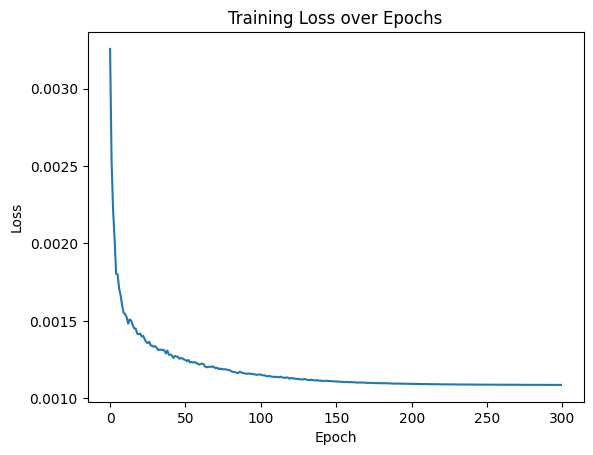

In [ ]:
import torch
from torch_geometric.data import Data
from torch_geometric.nn import GATConv
import matplotlib.pyplot as plt
import torch.nn.functional as F

driver = GraphDatabase.driver(url, auth=(username, password))

def get_graph_data_from_neo4j(driver):
    # Retrieve nodes with embeddings
    with driver.session() as session:
        nodes = session.run("""
            MATCH (n:Entity)
            RETURN id(n) AS node_id, n.embedding AS embedding, n.name AS name, n.definition AS definition
        """).data()

        edges = session.run("""
            MATCH (n:Entity)-[r]->(m:Entity)
            RETURN id(n) AS source_id, id(m) AS target_id
        """).data()

    # Process nodes and edges
    node_index = {node["node_id"]: i for i, node in enumerate(nodes)}  # Map Neo4j IDs to indices
    node_embeddings = [node["embedding"] for node in nodes]
    node_terms = [node["name"] for node in nodes]
    node_definitions = [node["definition"] for node in nodes]

    edge_index = [[node_index[edge["source_id"]], node_index[edge["target_id"]]] for edge in edges]
    edge_index = torch.tensor(edge_index, dtype=torch.long).t().contiguous()

    return torch.tensor(node_embeddings, dtype=torch.float), edge_index, node_terms, node_definitions

# Get embeddings and edges from Neo4j
node_features, edge_index, node_terms, node_definitions = get_graph_data_from_neo4j(driver)

# Create PyTorch Geometric Data object
graph_data = Data(
    x=node_features,
    edge_index=edge_index,
    terms=node_terms,
    definitions=node_definitions
)

# Define the Graph Autoencoder model
class GraphAutoencoder(torch.nn.Module):
    def __init__(self, input_dim=384, hidden_dim=128, output_dim=384, num_layers=4, heads=4):
        super(GraphAutoencoder, self).__init__()
        self.encoder_layers = torch.nn.ModuleList()
        for i in range(num_layers):
            in_dim = input_dim if i == 0 else hidden_dim * heads
            self.encoder_layers.append(GATConv(in_dim, hidden_dim, heads=heads, dropout=0.6, edge_dim=1))

        self.decoder_layers = torch.nn.ModuleList()
        for i in range(num_layers):
            out_dim = output_dim if i == num_layers - 1 else hidden_dim * heads
            self.decoder_layers.append(GATConv(hidden_dim * heads, out_dim, heads=1 if i == num_layers - 1 else heads, concat=False, dropout=0.6, edge_dim=1))

    def forward(self, x, edge_index, edge_attr=None):
        for layer in self.encoder_layers:
            x = F.elu(layer(x, edge_index, edge_attr))
        encoded = x
        for layer in self.decoder_layers:
            x = F.elu(layer(x, edge_index, edge_attr)) if layer != self.decoder_layers[-1] else layer(x, edge_index, edge_attr)
        decoded = x
        return decoded, encoded

# Initialize model and optimizer
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = GraphAutoencoder(input_dim=node_features.size(1)).to(device)
graph_data = graph_data.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.002, weight_decay=1e-5)

#Training
def train(data):
    model.train()
    optimizer.zero_grad()
    decoded, encoded = model(data.x, data.edge_index, data.edge_attr)
    loss = F.mse_loss(decoded, data.x)  # Mean squared error for reconstruction
    loss.backward()
    optimizer.step()
    return loss.item()

train_losses = []
for epoch in range(300):
    loss = train(graph_data)
    train_losses.append(loss)
    if (epoch + 1) % 20 == 0:
        print(f'Epoch {epoch+1}, Loss: {loss:.4f}')

# Visualization
plt.plot(train_losses)
plt.title("Training Loss over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.show()

#### Q&A Model

In [ ]:
from transformers import pipeline
from sentence_transformers import SentenceTransformer
import torch
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity
import matplotlib.pyplot as plt

# Initialize a Hugging Face question-answering pipeline
qa_pipeline = pipeline("question-answering", model="deepset/roberta-base-squad2")

# Step 1: Load Sentence-BERT model for question embedding
sentence_model = SentenceTransformer("all-MiniLM-L6-v2")  # 384-dimensional embeddings to match node embedding dimension

# Q&A function that retrieves relevant nodes based on similarity and answers the question
def query_graph_with_qa(question, node_embeddings, node_terms, node_definitions, top_k=3):
    # Step 2: Encode the question
    question_embedding = sentence_model.encode([question])

    # Step 3: Compute cosine similarity with node embeddings
    similarity_scores = cosine_similarity(question_embedding, node_embeddings.numpy())
    top_indices = similarity_scores.argsort()[0][::-1][:top_k]

    print(f"\nTop {top_k} relevant terms for the question '{question}':")
    answers = []
    for idx in top_indices:
        term = node_terms[idx]
        definition = node_definitions[idx]
        score = similarity_scores[0][idx]

        # Step 4: Use Q&A pipeline with the question and the context (definition of the term)
        answer = qa_pipeline(question=question, context=definition)
        answers.append((term, answer['answer'], answer['score']))

        print(f"Term: {term}, Similarity Score: {score:.4f}")
        print(f"Answer: {answer['answer']} (Confidence: {answer['score']:.4f})\n")

    return answers

# Example Usage
question = " Project management?"
query_graph_with_qa(question, node_features, node_terms, node_definitions, top_k=3)

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(



Top 3 relevant terms for the question ' Project management?':
Term: collaborative project team environment, Similarity Score: 0.2924
Answer: involves multiple contributing factors (Confidence: 0.0000)

Term: high-performing project teams, Similarity Score: 0.2919
Answer: project teams (Confidence: 0.0002)

Term: conflict management, Similarity Score: 0.2880
Answer: conflicts (Confidence: 0.0811)



[('collaborative project team environment',
  'involves multiple contributing factors',
  1.2021276418749949e-08),
 ('high-performing project teams', 'project teams', 0.0002445111167617142),
 ('conflict management', 'conflicts', 0.08105438202619553)]

### Method 2 : RAG (Retrieve and Generate)

In [ ]:
from langchain_huggingface import HuggingFaceEmbeddings

embedding_model = HuggingFaceEmbeddings(model_name="BAAI/bge-small-en-v1.5")

/usr/local/lib/python3.10/dist-packages/sentence_transformers/cross_encoder/CrossEncoder.py:13: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm, trange
/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/94.8k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/52.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/743 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/133M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/366 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/711k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

1_Pooling/config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

In [ ]:
neo4j_graph_vector_index = Neo4jVector.from_existing_graph(
    embedding = embedding_model,
    url = url,
    username = username,
    password = password,
    node_label="Entity",
    index_name = "entity",
    embedding_node_property="embedding",
    text_node_properties=["name","definition"]
)

#### **Simple texual output**

In [ ]:
loader = TextLoader("/content/extracted_text_with_figures.txt")

documents = loader.load()
text_splitter = RecursiveCharacterTextSplitter(chunk_size=1000, chunk_overlap=0)
docs = text_splitter.split_documents(documents)

In [ ]:
db = Neo4jVector.from_documents(
   docs, embedding_model, url=url, username=username, password=password
)

In [ ]:
query = "What is the relation between Value delivery and Project?"
docs_with_score = db.similarity_search_with_score(query, k=2)

In [ ]:
for doc, score in docs_with_score:
    print("-" * 80)
    print("Score: ", score)
    print(doc.page_content)
    print("-" * 80)

--------------------------------------------------------------------------------
Score:  0.8970012664794922
The information in this section provides a context for value delivery, governance, project 
functions, the project environment, and product management.
▶	
Section 2.1 Creating Value. This section describes how projects operate within a system
to produce value for organizations and their stakeholders.
▶	
Section 2.2 Organizational Governance Systems. This section describes how governance
supports a system for value delivery.
▶	
Section 2.3 Functions Associated with Projects. This section identifies the functions
that support projects.
▶	
Section 2.4 The Project Environment. This section identifies internal and external
factors that influence projects and the delivery of value.
▶	
Section 2.5 Product Management Considerations. This section identifies the ways
portfolios, programs, projects, and products relate.
2.1  CREATING VALUE
Projects exist within a larger system, such as a go

In [ ]:
# Perform a similarity search as an example retrieval
result = neo4j_graph_vector_index.similarity_search("Value delivery", k=5)

In [ ]:
result

[Document(metadata={}, page_content='\nname: value delivery\ndefinition: A systems focus for value delivery changes the perspective from one of governing portfolios, programs, and projects to focusing on the value chain that links those and other business capabilities to advancing organizational strategy, value, and business objectives.'),
 Document(metadata={}, page_content='\nname: system for value delivery\ndefinition: A collection of strategic business activities aimed at building, sustaining, and/or advancing an organization.'),
 Document(metadata={}, page_content='\nname: governance\ndefinition: supports a system for value delivery.'),
 Document(metadata={}, page_content='\nname: project delivery\ndefinition: Project delivery with little or no negative impact from unforeseen events or conditions'),
 Document(metadata={}, page_content='\nname: value delivery office (vdo)\ndefinition: The ACoE/VDO serves an enabling role, rather than a management or oversight function.')]

In [ ]:
prompt = """
Your Job is to use the provided retriever data to answer
questions about the Peoject management PMBOK.
Use the following context to answer questions.
Be as detailed as possible, but don't make up any information that's
not from the context. If you don't know an answer, say you don't know.
{context}
"""

In [ ]:
system_prompt = SystemMessagePromptTemplate(
    prompt=PromptTemplate(
        template=prompt,
        input_variables=["context"]
    )
)

In [ ]:
human_prompt = HumanMessagePromptTemplate(
    prompt=PromptTemplate(
        template="Can you provide details on: {question}",
        input_variables=["question"]
    )
)

In [ ]:
messages = [system_prompt, human_prompt]

In [ ]:
llm = ChatGroq(
    model="llama-3.2-90b-text-preview",
)

In [ ]:
qa_prompt = ChatPromptTemplate(
    messages=messages,
    input_variables=["context","question"]
)

In [ ]:
qa_chain_text = RetrievalQA.from_chain_type(
    llm,
    retriever=db.as_retriever(),
    chain_type = "stuff"
)

In [ ]:
qa_chain_text.combine_documents_chain.llm_chain.prompt = qa_prompt

In [ ]:
qa_chain_text.invoke("What is project management?")

{'query': 'What is project management?',
 'result': 'According to the provided context, Project Management is defined as:\n\n"Project Management. The application of knowledge, skills, tools, and techniques to project activities to meet the project requirements."\n\nAdditionally, the context states that Project Management refers to guiding the project work to deliver the intended outcomes, and project teams can achieve the outcomes using a broad range of approaches (e.g., predictive, hybrid, and adaptive).\n\nIn essence, Project Management involves using various knowledge, skills, tools, and techniques to manage project activities to meet the project\'s objectives and requirements, with the ultimate goal of delivering the intended outcomes and creating value for the organization and stakeholders.'}

#### **Figure Retrieval**

In [ ]:
import os
import base64
import numpy as np
from sentence_transformers import SentenceTransformer
from sklearn.metrics.pairwise import cosine_similarity


figures_folder = "/extracted_figures"
figures_txt_path = "/List_Figures_Tables.txt"

model = SentenceTransformer('all-MiniLM-L6-v2')

query = "What is the relation between Value delivery and Project?"


def load_figures_from_txt(file_path):
    with open(file_path, "r") as f:
        figures_list = f.readlines()
    figures_list = [figure.strip() for figure in figures_list]
    return figures_list

figures_list = load_figures_from_txt(figures_txt_path)


def compute_embeddings(text_list):
    return model.encode(text_list)

query_embedding = model.encode([query])[0]
figure_embeddings = compute_embeddings(figures_list)


def compute_similarity(query_embedding, figure_embeddings):
    return cosine_similarity([query_embedding], figure_embeddings)[0]

similarity_scores = compute_similarity(query_embedding, figure_embeddings)


def rank_figures_by_similarity(figures_list, similarity_scores, top_k=2):
    ranked_results = []
    for i, score in enumerate(similarity_scores):
        ranked_results.append((figures_list[i], score))


    ranked_results.sort(key=lambda x: x[1], reverse=True)
    return ranked_results[:top_k]


ranked_figures = rank_figures_by_similarity(figures_list, similarity_scores, top_k=2)


def remove_duplicates(results):
    seen = set()
    unique_results = []
    for result in results:
        if result[0] not in seen:
            unique_results.append(result)
            seen.add(result[0])
    return unique_results

ranked_figures = remove_duplicates(ranked_figures)


def display_relevant_figures(figures_folder, ranked_figures):
    all_figure_files = os.listdir(figures_folder)

    for figure_title, score in ranked_figures:
        print(f"Matched figure: {figure_title} (score: {score:.2f})")
        matched_files = [file for file in all_figure_files if figure_title in file]

        if matched_files:
            figure_path = os.path.join(figures_folder, matched_files[0])
            with open(figure_path, "rb") as image_file:
                image_base64 = base64.b64encode(image_file.read()).decode('utf-8')
            print(f"Image Base64 (preview): {image_base64[:100]}...")
            print("-" * 80)
        else:
            print(f"No matching image file found for {figure_title}")

#Example
if ranked_figures:
    display_relevant_figures(figures_folder, ranked_figures)
else:
    print("No relevant figures matched the query.")

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


Matched figure: Figure 2-1. Example of a System for Value Delivery (score: 0.56)
Image Base64 (preview): iVBORw0KGgoAAAANSUhEUgAAB74AAARaCAIAAABUt0rOAAEAAElEQVR4nOzddXxT1//H8ZOkqbvTQlukuFvR4jDGmDE2pmzMt+9c...
--------------------------------------------------------------------------------
Matched figure: Figure 2-2. Components of a Sample System for Value Delivery (score: 0.52)
Image Base64 (preview): iVBORw0KGgoAAAANSUhEUgAAB74AAAUMCAIAAAAoF6qQAAEAAElEQVR4nOzdd3xT9b/H8ZN07z1oyy57lr23yJYlIG5Q3IiKiggo...
--------------------------------------------------------------------------------


#### **Q&A Model : Chatbot with conversation memory**

In [ ]:
from langchain.schema import format_document
from langchain_core.messages import get_buffer_string
from langchain_core.runnables import RunnableLambda, RunnablePassthrough
from langchain.memory import ConversationBufferMemory
from langchain.prompts.prompt import PromptTemplate
from langchain_core.prompts.chat import ChatPromptTemplate

from operator import itemgetter

In [ ]:
_template = """
Given the following conversation and a follow up question, rephrase the follow up question to be a standalone question, in its original language, that can be used to query a FAISS index. This query will be used to retrieve documents with additional context.

Let me share a couple examples that will be important.

If you do not see any chat history, you MUST return the "Follow Up Input" as is:

```
Chat History:

Follow Up Input: What is Value delivery??
Standalone Question:
What is Value delivery?
```

If this is the second question onwards, you should properly rephrase the question like this:

```
Chat History:
Human: What is Value delivery?
AI:
"A systems focus for value delivery changes the perspective from one of governing portfolios, programs, and projects to focusing on the value chain that links those and other business capabilities to advancing organizational strategy, value, and business objectives.

Follow Up Input: What was its focus?
Standalone Question:
What was its focus?
```

Now, with those examples, here is the actual chat history and input question.

Chat History:
{chat_history}

Follow Up Input: {question}
Standalone question:
[your response here]
"""
CONDENSE_QUESTION_PROMPT = PromptTemplate.from_template(_template)

In [ ]:
template = """
Your Job is to use the provided retriever data to answer
questions about the Peoject management PMBOK.
Use the following context to answer questions.
Be as detailed as possible, but don't make up any information that's
not from the context. If you don't know an answer, say you don't know.
{context}

Question: {question}
"""
ANSWER_PROMPT = ChatPromptTemplate.from_template(template)

In [ ]:
DEFAULT_DOCUMENT_PROMPT = PromptTemplate.from_template(template="{page_content}")

def _combine_documents(
    docs, document_prompt=DEFAULT_DOCUMENT_PROMPT, document_separator="\n\n"
):
    doc_strings = [format_document(doc, document_prompt) for doc in docs]
    return document_separator.join(doc_strings)

In [ ]:
retriever=neo4j_graph_vector_index.as_retriever(k=10)

In [ ]:
memory = ConversationBufferMemory(
 return_messages=True, output_key="answer", input_key="question"
)

loaded_memory = RunnablePassthrough.assign(
    chat_history=RunnableLambda(memory.load_memory_variables) | itemgetter("history"),
)
standalone_question = {
    "standalone_question": {
        "question": lambda x: x["question"],
        "chat_history": lambda x: get_buffer_string(x["chat_history"]),
    }
    | CONDENSE_QUESTION_PROMPT
    | (llm | (lambda message: message.content))
}
retrieved_documents = {
    "docs": itemgetter("standalone_question") | retriever,
    "question": lambda x: x["standalone_question"],
}
final_inputs = {
    "context": lambda x: _combine_documents(x["docs"]),
    "question": itemgetter("question"),
}
answer = {
    "answer": final_inputs | ANSWER_PROMPT | (llm | (lambda message: message.content)),
    "question": itemgetter("question"),
    "context": final_inputs["context"]
}
final_chain = loaded_memory | standalone_question | retrieved_documents | answer

In [ ]:
def call_conversational_rag(question, chain, memory):
    """
    Calls a conversational RAG (Retrieval-Augmented Generation) model to generate an answer to a given question.

    This function sends a question to the RAG model, retrieves the answer, and stores the question-answer pair in memory
    for context in future interactions.

    Parameters:
    question (str): The question to be answered by the RAG model.
    chain (LangChain object): An instance of LangChain which encapsulates the RAG model and its functionality.
    memory (Memory object): An object used for storing the context of the conversation.

    Returns:
    dict: A dictionary containing the generated answer from the RAG model.
    """

    # Prepare the input for the RAG model
    inputs = {"question": question}

    # Invoke the RAG model to get an answer
    result = chain.invoke(inputs)

    # Save the current question and its answer to memory for future context
    memory.save_context(inputs, {"answer": result["answer"]})

    # Return the result
    return result

In [ ]:
question = "What is the Value delivery?"
call_conversational_rag(question, final_chain, memory)

{'answer': "According to the provided context, Value delivery is defined as a system's focus for delivering value. It is characterized by a shift in perspective from governing portfolios, programs, and projects to focusing on the value chain that links those and other business capabilities to advancing organizational strategy, value, and business objectives.",
 'question': 'Since this is the first question, the standalone question remains the same as the follow-up input. \n\nStandalone Question:\nWhat is the Value delivery?',
 'context': '\nname: incremental delivery\ndefinition: Is this something the project team can develop and get stakeholder feedback on incrementally, or something that is hard to evaluate until near completion?\n\n\nname: value delivery\ndefinition: A systems focus for value delivery changes the perspective from one of governing portfolios, programs, and projects to focusing on the value chain that links those and other business capabilities to advancing organizati

In [ ]:
question = "What is its focus?"
call_conversational_rag(question, final_chain, memory)

{'answer': "The focus of Value Delivery's system is on the value chain that links portfolios, programs, projects, and other business capabilities to advancing organizational strategy, value, and business objectives.",
 'question': "What is the focus of Value delivery's system?",
 'context': '\nname: value delivery\ndefinition: A systems focus for value delivery changes the perspective from one of governing portfolios, programs, and projects to focusing on the value chain that links those and other business capabilities to advancing organizational strategy, value, and business objectives.\n\n\nname: system for value delivery\ndefinition: A collection of strategic business activities aimed at building, sustaining, and/or advancing an organization.\n\n\nname: systems view\ndefinition: A systems view of project management as part of The Standard for Project Management and continues with the presentation of the content. A systems focus for value delivery changes the perspective from one of 

In [ ]:
question = "How does it deal with project management?"
call_conversational_rag(question, final_chain, memory)

{'answer': 'Based on the provided context, a systems view of project management is presented as part of The Standard for Project Management, and it continues with a systems focus for value delivery. \n\nIn this system, the focus of project management changes from governing portfolios, programs, and projects to focusing on the value chain that links those and other business capabilities to advancing organizational strategy, value, and business objectives.\n\nThis means that project management is viewed as part of a larger system, with the goal of delivering value by focusing on the value chain and advancing organizational strategy and objectives.',
 'question': "How does Value delivery's system deal with project management?",
 'context': '\nname: system for value delivery\ndefinition: A collection of strategic business activities aimed at building, sustaining, and/or advancing an organization.\n\n\nname: value delivery\ndefinition: A systems focus for value delivery changes the perspect

## Reasoning models

#### Load the necessay documents

In [ ]:
# Load the extracted text file
with open("extracted_text.txt", "r") as file:
    extracted_text = file.read()

print(extracted_text[:500])

# Load edges data
edges_data = pd.read_csv("edges.csv")
print(edges_data.head())

# Load terms and definitions
terms_data = pd.read_csv("terms.csv")
print(terms_data.head())

STANDARD FOR 
PROJECT MANAGEMENT

Introduction
The Standard for Project Management identifies project management principles that guide the 
behaviors and actions of project professionals and other stakeholders who work on or are engaged 
with projects.
This introductory section describes the purpose of this standard, defines key terms and 
concepts, and identifies the audience for the standard.
The Standard for Project Management consists of the following sections:
	
Section 1 Introduction
	
Sec
                                              node_1  \
0  project management institute (pmi) standards a...   
1  project management institute (pmi) standards a...   
2  project management institute (pmi) standards a...   
3  project management institute (pmi) standards a...   
4                   managing change in organizations   

                                              node_2  \
0  project management institute (pmi) standards a...   
1       project management body of knowledge (pmbo

In [ ]:
import networkx as nx

# Initialize a directed graph
G = nx.DiGraph()

# Add nodes from terms_data with definitions as attributes
for _, row in terms_data.iterrows():
    G.add_node(row['chunk_id'], definition=row['definition'])

# Add edges based on the relationships in edges_data
for _, row in edges_data.iterrows():
    G.add_edge(row['node_1'], row['node_2'], relationship=row['edge'])

print(f"Graph has {G.number_of_nodes()} nodes and {G.number_of_edges()} edges.")


Graph has 875 nodes and 1105 edges.


In [ ]:
from transformers import pipeline

# Load a pre-trained QA pipeline
qa_pipeline = pipeline("question-answering", model="distilbert-base-cased-distilled-squad")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/473 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/261M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/49.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/213k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/436k [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


In [ ]:
import pandas as pd

# Load terms data
terms_data = pd.read_csv("terms.csv")

# Prepare a list of contexts (corpus) for QA
corpus = []
for _, row in terms_data.iterrows():
    corpus.append({
        "chunk_id": row['chunk_id'],
        "text": row['definition']
    })

# Optionally, append text from extracted_text.txt for broader context
with open("extracted_text.txt", "r") as file:
    extracted_text = file.read()
    corpus.append({"chunk_id": "full_text", "text": extracted_text})

In [ ]:
from sentence_transformers import SentenceTransformer, util
import torch

# Load a Sentence-BERT model for retrieving relevant contexts
retrieval_model = SentenceTransformer('all-MiniLM-L6-v2')
corpus_embeddings = retrieval_model.encode([entry['text'] for entry in corpus], convert_to_tensor=True)

# Define the QA function
def answer_question(query, top_k=3):
    # Encode the query for context retrieval
    query_embedding = retrieval_model.encode(query, convert_to_tensor=True)

    # Find the top_k most relevant contexts
    hits = util.semantic_search(query_embedding, corpus_embeddings, top_k=top_k)[0]
    relevant_texts = [corpus[hit['corpus_id']]['text'] for hit in hits]
    chunk_ids = [corpus[hit['corpus_id']]['chunk_id'] for hit in hits]

    # Run the QA model on each relevant text segment and collect answers
    answers = []
    for i, context in enumerate(relevant_texts):
        result = qa_pipeline({
            "question": query,
            "context": context
        })
        answers.append({
            "chunk_id": chunk_ids[i],
            "answer": result['answer'],
            "score": result['score'],
            "context": context
        })

    # Sort answers by score and return
    answers = sorted(answers, key=lambda x: x['score'], reverse=True)
    return answers

# Example question
question = "What is the process for risk management?"
answers = answer_question(question)

# Display top answers
for ans in answers:
    print(f"Chunk ID: {ans['chunk_id']}")
    print(f"Answer: {ans['answer']}")
    print(f"Score: {ans['score']}\n")
    print(f"Context: {ans['context'][:200]}...\n")  # Show part of the context for reference

modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/10.7k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


1_Pooling/config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

Chunk ID: 36217f9818b845d0a50a285e5437e849
Answer: A repository
Score: 0.5456775426864624

Context: A repository in which outputs of risk management processes are recorded....

Chunk ID: 0d4fe7a03b244b6e8c60afbdab4e70da
Answer: project document
Score: 0.40968722105026245

Context: This project document is developed progressively throughout the risk management processes and summarizes information on individual project risks and the level of overall project risk....

Chunk ID: 0493316ed9174d37a2918da68e5f48fe
Answer: project, program, or portfolio management plan
Score: 0.3408195972442627

Context: This plan is a component of the project, program, or portfolio management plan that describes how risk management activities will be structured and performed....



In [ ]:
# Define the question
question = "explain the process for risk management?"

# Use the QA system to answer the question
answers = answer_question(question)

# Display the top answer
for ans in answers[:1]:  # Only showing the top answer for simplicity
    print(f"Chunk ID: {ans['chunk_id']}")
    print(f"Answer: {ans['answer']}")
    print(f"Score: {ans['score']}\n")
    print(f"Context: {ans['context']}")  # Display the first 200 characters of context

Chunk ID: 36217f9818b845d0a50a285e5437e849
Answer: A repository
Score: 0.48345598578453064

Context: A repository in which outputs of risk management processes are recorded.


In [ ]:
# Define the question
question = "What are the key components of a project charter?"

# Run the QA system
answers = answer_question(question)

# Display top answer
for ans in answers[:1]:
    print(f"Chunk ID: {ans['chunk_id']}")
    print(f"Answer: {ans['answer']}")
    print(f"Score: {ans['score']}\n")
    print(f"Context: {ans['context']}")

Chunk ID: 555db0c05b7d4f37a0ac514b0c92a7ee
Answer: team charter
Score: 0.6426547765731812

Context: Project charter, team charter


In [ ]:
def multi_hop_answer_question(query, top_k=3, max_hops=2):
    # Step 1: Initial retrieval to find the primary node
    primary_answer = answer_question(query, top_k=1)[0]
    primary_chunk_id = primary_answer['chunk_id']

    # Step 2: Use graph traversal to find related nodes
    related_contexts = [primary_answer]
    visited = set([primary_chunk_id])
    current_level = [primary_chunk_id]

    for hop in range(max_hops):
        next_level = []
        for chunk_id in current_level:
            # Get neighboring nodes
            neighbors = list(G.neighbors(chunk_id))
            for neighbor in neighbors:
                if neighbor not in visited:
                    # Get context from each neighbor node
                    context = next((entry for entry in corpus if entry['chunk_id'] == neighbor), None)
                    if context:
                        related_contexts.append(context)
                        next_level.append(neighbor)
                    visited.add(neighbor)
        current_level = next_level

    # Aggregate answers from related contexts using the QA pipeline
    combined_answer = ""
    for context in related_contexts:
      print(context)
      if 'text' in context:
        result = qa_pipeline({
            "question": query,
            "context": context['text']
        })
        combined_answer += f"{result['answer']} "
      else:
        print(f"No 'text' key in context: {context}")

    return combined_answer.strip()

In [ ]:
question = "How should I handle risks within project constraints?"
answer = multi_hop_answer_question(question)
print(answer)

{'chunk_id': '3202fd5241334035818d521cec4c56a3', 'answer': 'opportunities and threats', 'score': 0.17915081977844238, 'context': 'The set of opportunities and threats comprise the set of project risks.'}
No 'text' key in context: {'chunk_id': '3202fd5241334035818d521cec4c56a3', 'answer': 'opportunities and threats', 'score': 0.17915081977844238, 'context': 'The set of opportunities and threats comprise the set of project risks.'}



In [ ]:
def process_reasoning(start_node):
    steps = []
    current_node = start_node
    visited = set()

    while current_node and current_node not in visited:
        visited.add(current_node)
        steps.append({
            "step": current_node,
            "description": G.nodes[current_node].get("definition", "")
        })
        # Move to the next node in sequence if it exists
        neighbors = list(G.successors(current_node))
        current_node = neighbors[0] if neighbors else None

    return steps

In [ ]:
for node in G.nodes:
    print(f"Node: {node}, Attributes: {G.nodes[node]}")

Node: 141950690a4f4548be9b9742f7323820, Attributes: {'definition': 'developed through a voluntary consensus standards development process'}
Node: a904499fc27541db89ce31f775cb8163, Attributes: {'definition': 'Produces more holistic solutions than the thoughts of one individual'}
Node: 177f6d239eeb4c4b9ab8500e68bfee07, Attributes: {'definition': 'meaning applicable to most projects most of the time with widespread consensus that practices have value and usefulness.'}
Node: fba9c65269d5499f841f7168b289354f, Attributes: {'definition': 'A standard that supports effective project management and focuses more on the full value delivery landscape, allowing for adaptability and evolution in a rapidly changing project management landscape.'}
Node: f1af86e4ecac45faacebd65fd6970ec1, Attributes: {'definition': 'Statements that capture and summarize generally accepted objectives for the practice of project management and its core functions.'}
Node: af2daee474924ef092473d9c029d0897, Attributes: {'defi

In [ ]:
start_process = "executing process group"
steps = process_reasoning(start_process)

for i, step in enumerate(steps, 1):
    print(f"Step {i}: {step['step']}")
    print(f"Description: {step['description']}\n")

Step 1: executing process group
Description: 

Step 2: integrated project management plan
Description: 

Step 3: cost management plan
Description: 

Step 4: project management institute (pmi) standards and guideline publications
Description: 



In [ ]:
def conditional_reasoning(query):
    # Basic response
    base_answer = answer_question(query)[0]
    answer_text = base_answer['answer']

    if "constraint" in query.lower():
        answer_text += "\nConsider constraints in terms of scope, budget, and timelines when planning risk responses."
    if "resource" in query.lower():
        answer_text += "\nMake sure to assess resource availability and constraints during each phase."

    return answer_text

In [ ]:
question = "How should I manage risks with limited resources?"
answer = conditional_reasoning(question)
print(answer)

a hierarchical representation
Make sure to assess resource availability and constraints during each phase.


#### **The selected methods in this notebook were implemented in the backend of the web application we created using flask and react node.js**